# Convnet Model and Training

This aim of notebook is to define the siamese model that will be used for the Humpback Whale challenge. It will also run the model to trainin it agains our previously generated training and validation dataset and also create the results agains a test dataset.

## 0. Module Imports 

In [1]:
import numpy as np
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1. Load Training, Validation and Test datasets

In [2]:
pickle_file = '../data/Siamese_dataset.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_X1_dataset = save['train_X1_dataset']
    train_X2_dataset = save['train_X2_dataset']
    train_labels = save['train_labels']
    valid_X1_dataset = save['valid_X1_dataset']
    valid_X2_dataset = save['valid_X2_dataset']
    valid_labels = save['valid_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_X1_dataset.shape, train_X2_dataset.shape, train_labels.shape)
    print('Validation set', valid_X1_dataset.shape, valid_X2_dataset.shape, valid_labels.shape)
    train_labels = np.ones(train_labels.shape,dtype=float) - train_labels
    valid_labels = np.ones(valid_labels.shape,dtype=float) - valid_labels

Training set (31218, 44, 100) (31218, 44, 100) (31218,)
Validation set (5510, 44, 100) (5510, 44, 100) (5510,)


##  2. Declaration of Global Constants
Now we declare all the global constants in hee in orde to have them centralized.
This way we can easyly tune our model.

In [56]:
## Image parameters
NUM_CHANNELS = 1
IMAGE_HEIGHT = train_X1_dataset.shape[1]
IMAGE_WIDHT = train_X1_dataset.shape[2]

#Convnet parameters
BETA1 = 0.005
BETA2 = 0.0001
PATCH_1 = 14
PATCH_2 = 12
DEPTH_1 = 15
DEPTH_2 = 45
NUM_HIDEN_1 = 1600
NUM_HIDEN_2 = 800
EMBEDDING = 3
NUM_LABELS = 1
MARGIN = 50.0
max_value = 0.5 * MARGIN / pow(EMBEDDING, 0.5)
min_value = -0.5 * MARGIN / pow(EMBEDDING, 0.5)
print(max_value)
print(min_value)


#Training parameters
BATCH_SIZE = 128
NUM_STEPS = 1001
THRESHOLD = 9.5

14.4337567297
-14.4337567297


## 3. Reformat datasets into a TensorFlow-friendly shape:

- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.



In [4]:
num_labels = 1

def reformat(dataset1, dataset2, labels):
  dataset1 = dataset1.reshape(
    (-1, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS)).astype(np.float32)
  dataset2 = dataset2.reshape(
    (-1, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset1, dataset2, labels
train_X1_dataset, train_X2_dataset, train_labels = reformat(train_X1_dataset, train_X2_dataset, train_labels)
valid_X1_dataset, valid_X2_dataset, valid_labels = reformat(valid_X1_dataset, valid_X2_dataset, valid_labels)
print('Training set', train_X1_dataset.shape, train_X2_dataset.shape, train_labels.shape)
print('Validation set', valid_X1_dataset.shape, valid_X2_dataset.shape, valid_labels.shape)

Training set (31218, 44, 100, 1) (31218, 44, 100, 1) (31218, 1)
Validation set (5510, 44, 100, 1) (5510, 44, 100, 1) (5510, 1)


## 4. Definition of auxiliar functions

### 4.1. Accuracy computation

In [57]:
def accuracy(distance, labels):
    positives = np.where(labels[:, 0] > 0)
    negatives = np.where(labels[:, 0] == 0)
    mean_p_distance = np.mean(distance[positives[0]])
    mean_n_distance = np.mean(distance[negatives[0]])
    aux = distance < (mean_p_distance + mean_n_distance)/2
    equal = np.equal(aux[:] , labels[:, 0])
    great = np.greater(aux[:] , labels[:, 0])
    less = np.less(aux[:] , labels[:, 0])
    acc = (100.0 * np.sum(equal.astype(np.float32))
          / distance.shape[0])
    false_pos = np.sum(great.astype(np.float32))
    false_neg = np.sum(less.astype(np.float32))
    return acc, false_pos, false_neg

def print_means(distance, labels):
    print(distance.shape)
    print(labels.shape)
    positives = np.where(labels[:, 0] > 0)
    negatives = np.where(labels[:, 0] == 0)
    print(positives[0].shape)
    print(negatives[0].shape)
    mean_p_distance = np.mean(distance[positives[0]])
    mean_n_distance = np.mean(distance[negatives[0]])
    
    
    plt.figure(figsize=(10, 4))

    # the histogram of the data
    n, bins, patches = plt.hist(distance[positives[0]], 100, normed=1, facecolor='green', alpha=0.2)
    n, bins, patches = plt.hist(distance[negatives[0]], 100, normed=1, facecolor='red', alpha=0.2)
    
    plt.xlabel('Aspect ratio')
    plt.ylabel('Probability')
    plt.title('Histogram of Aspect Ratios')
    plt.axis([0, MARGIN, 0, 0.5])
    plt.grid(True)
    plt.show()
    
    print('Mean negative distance ' +  str(mean_n_distance) + ' mean positive distance ' + str(mean_p_distance))

## 5. Network declaration
We will use tensorflow

In [60]:

siamese_model = tf.Graph()

with siamese_model.as_default():

  # Input data.
    tf_train_X1_dataset = tf.placeholder(\
          tf.float32, shape=(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS))
    tf_train_X2_dataset = tf.placeholder(\
          tf.float32, shape=(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS))
    tf_train_labels = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_LABELS))
    tf_valid_X1_dataset = tf.constant(valid_X1_dataset)
    tf_valid_X2_dataset = tf.constant(valid_X2_dataset)
    #tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    weights = {
      'layer1': tf.Variable(tf.truncated_normal(\
              [PATCH_1, PATCH_1, NUM_CHANNELS, DEPTH_1], stddev=0.01)),
      'layer2': tf.Variable(tf.truncated_normal(\
              [PATCH_2, PATCH_2, DEPTH_1, DEPTH_2], stddev=0.01)),
      'layer3': tf.Variable(tf.truncated_normal(\
              [12375, NUM_HIDEN_1], stddev=0.01)),
      'layer4': tf.Variable(tf.truncated_normal(\
              [NUM_HIDEN_1, NUM_HIDEN_2], stddev=0.01)),
      'layer5': tf.Variable(tf.truncated_normal(\
              [NUM_HIDEN_2, EMBEDDING], stddev=0.01))
      }
    biases = {
        'layer1' : tf.Variable(tf.zeros([DEPTH_1])),
        'layer2' : tf.Variable(tf.constant(0.1, shape=[DEPTH_2])),
        'layer3' : tf.Variable(tf.constant(0.1, shape=[NUM_HIDEN_1])),
        'layer4' : tf.Variable(tf.constant(0.1, shape=[NUM_HIDEN_2])),
        'layer5' : tf.Variable(tf.constant(0.1, shape=[EMBEDDING]))
        }
  
  # Model.
    def model(data):
        conv = tf.nn.conv2d(data, weights['layer1'], [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + biases['layer1'])
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, weights['layer2'], [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + biases['layer2'])
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        shape = pool.get_shape().as_list()
        print(shape)
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, weights['layer3']) + biases['layer3'])
        hidden = tf.matmul(hidden, weights['layer4']) + biases['layer4']
        logits = tf.matmul(hidden, weights['layer5']) + biases['layer5']
        return tf.clip_by_value( logits, min_value, max_value, name=None)

    
    
    
  # Training computation.
    with tf.variable_scope("siamese") as scope:
        logits1 = model(tf_train_X1_dataset)
        scope.reuse_variables()
        logits2 = model(tf_train_X2_dataset)
        
    with tf.variable_scope("siamese_val") as scope:
        val_logits1 = model(tf_valid_X1_dataset)
        scope.reuse_variables()
        val_logits2 = model(tf_valid_X2_dataset)
        
    def loss(y):
        labels_t = y
        labels_f = tf.subtract(1.0, y, name="1-yi")          # labels_ = !labels;
        disperssion = BETA2 * tf.reduce_sum(tf.add(tf.pow(logits1, 2),tf.pow(logits2, 2)), 1)
        eucd2 = tf.pow(tf.subtract(logits1, logits2), 2)
        eucd2 = tf.reduce_sum(eucd2, 1)
        eucd = tf.sqrt(eucd2+1e-6, name="eucd")
        C = tf.constant(MARGIN, name="C")
        # yi*||CNN(p1i)-CNN(p2i)||^2 + (1-yi)*max(0, C-||CNN(p1i)-CNN(p2i)||^2)
        pos = tf.multiply(labels_t, eucd2, name="yi_x_eucd2")
        # neg = tf.multiply(labels_f, tf.subtract(0.0,eucd2), name="yi_x_eucd2")
        # neg = tf.multiply(labels_f, tf.maximum(0.0, tf.subtract(C,eucd2)), name="Nyi_x_C-eucd_xx_2")
        neg = tf.multiply(labels_f, tf.pow(tf.maximum(tf.subtract(C, eucd), 0), 2), name="Nyi_x_C-eucd_xx_2")
        losses = tf.add(pos, neg, name="losses")
        loss = tf.reduce_mean(losses, name="loss")
        return loss
    
    def loss_paper(y):
        labels_i = y
        labels_g = tf.subtract(1.0, y, name="1-yi")          # labels_ = !labels;
        disperssion = BETA1 * (   tf.nn.l2_loss(weights['layer1'])
                                + tf.nn.l2_loss(weights['layer2'])
                                + tf.nn.l2_loss(weights['layer3'])
                                + tf.nn.l2_loss(weights['layer4'])
                                + tf.nn.l2_loss(weights['layer5']) )
        #disperssion = disperssion + BETA2 * tf.reduce_sum(tf.add(tf.pow(logits1, 2),tf.pow(logits2, 2)), 1)
        ew2 = tf.pow(tf.subtract(logits1, logits2), 2)
        ew2 = tf.reduce_sum(ew2, 1)
        ew = tf.sqrt(ew2+1e-6, name="ew")
        Q = tf.constant(MARGIN, name="Q")
        # yi*||CNN(p1i)-CNN(p2i)||^2 + (1-yi)*max(0, C-||CNN(p1i)-CNN(p2i)||^2)
        pos = labels_g * ew2 * 2 / Q
        # neg = tf.multiply(labels_f, tf.subtract(0.0,eucd2), name="yi_x_eucd2")
        # neg = tf.multiply(labels_f, tf.maximum(0.0, tf.subtract(C,eucd2)), name="Nyi_x_C-eucd_xx_2")
        neg = labels_i *2 * Q * tf.exp( - 2.77 * ew / Q) 
        losses = tf.add(pos, neg, name="losses")
        losses = tf.add(losses, disperssion)
        loss = tf.reduce_sum(losses, name="loss")
        return loss
    
        
    loss = loss_paper(tf_train_labels)
    
  # Optimizer.
    optimizer = tf.train.AdamOptimizer().minimize(loss)
  
  
  # Predictions for the training, validation, and test data.
    train_prediction = tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(logits1, logits2), 2),1)+1e-6)
    valid_prediction = tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(val_logits1, val_logits2), 2),1)+1e-6)
    #test_prediction = tf.nn.softmax(model(tf_test_dataset))

    #num = tf.reduce_sum(logits1 * logits2, axis = 1)
    #print(num.shape)
    #den = tf.sqrt(tf.reduce_sum(tf.pow(logits1, 2),1)) * tf.sqrt(tf.reduce_sum(tf.pow(logits2, 2),1))
    #train_prediction = num/den
    #num = tf.reduce_sum(val_logits1 * val_logits2, axis = 1)
    #den = tf.sqrt(tf.reduce_sum(tf.pow(val_logits1, 2),1)) * tf.sqrt(tf.reduce_sum(tf.pow(val_logits2, 2),1))
    #valid_prediction = num/den
    embedding1 = val_logits1
    embedding2 = val_logits2

[128, 11, 25, 45]
[128, 11, 25, 45]
[5510, 11, 25, 45]
[5510, 11, 25, 45]


## 6. Model training

Initialized
Minibatch loss at step 0 860650.1875
Minibatch accuracy: 61.71875 false positives: 30.0 false negatives: 19.0
Validation accuracy: 69.7640653358 false positives: 1239.0 false negatives: 427.0
(5510,)
(5510, 1)
(2582,)
(2928,)


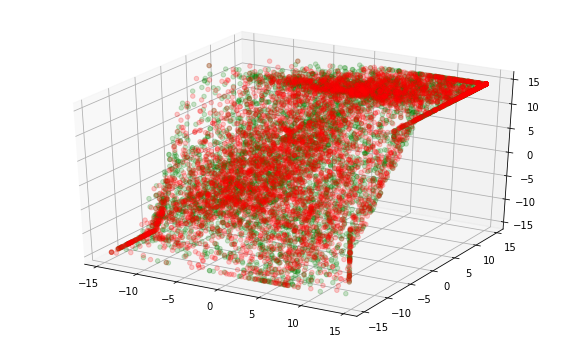

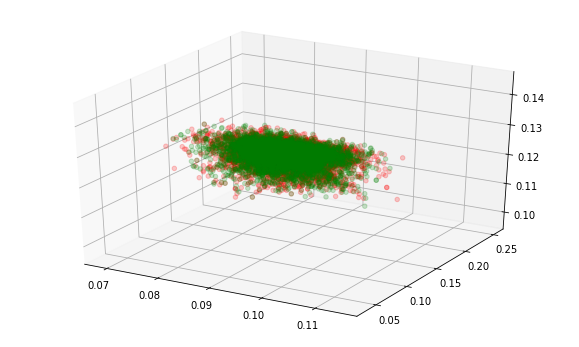

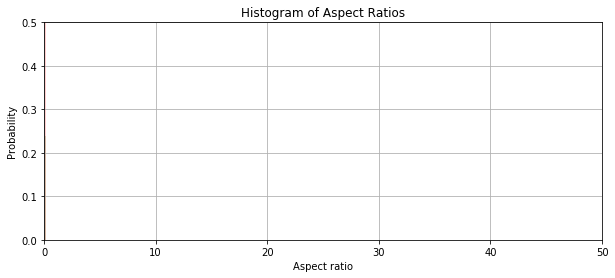

Mean negative distance 0.0482663 mean positive distance 0.0188818
Minibatch loss at step 50 477410.5
Minibatch accuracy: 75.0 false positives: 17.0 false negatives: 15.0
Validation accuracy: 68.7114337568 false positives: 1019.0 false negatives: 705.0
(5510,)
(5510, 1)
(2582,)
(2928,)


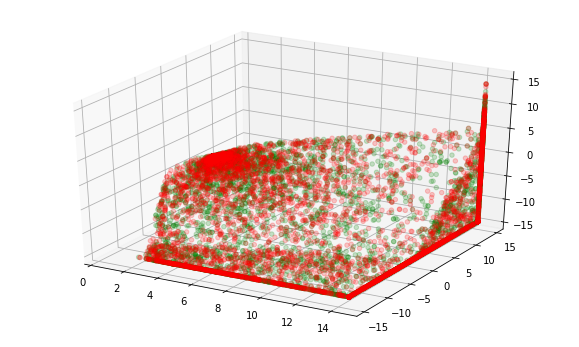

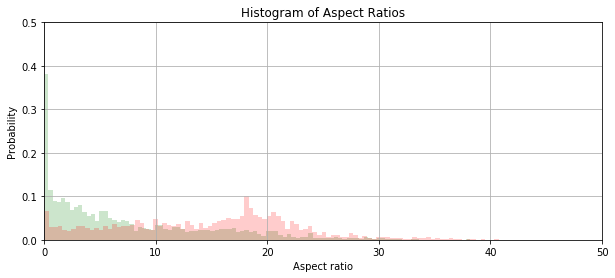

Mean negative distance 14.4622 mean positive distance 7.36527


In [ ]:
#Plots
P_FREQ = 50
losses = []
accuracies = []
rates = []

with tf.Session(graph=siamese_model) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(NUM_STEPS):
    offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
    batch_data_X1 = train_X1_dataset[offset:(offset + BATCH_SIZE), :, :, :]
    batch_data_X2 = train_X2_dataset[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE), :]
    feed_dict = {tf_train_X1_dataset : batch_data_X1, tf_train_X2_dataset : batch_data_X2, \
                 tf_train_labels : batch_labels}
    _, _loss, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if np.isnan(_loss):
        print('Model diverged with loss = NaN')
        quit()
        
    #Plot variables
    if (step % P_FREQ == 0):
      losses.append(_loss)
      distances = valid_prediction.eval()
      acc, fp, fn = accuracy(distances, valid_labels)
      accuracies.append(acc)
      rates.append(float(fp/fn))
      embeddings1 = embedding1.eval()
      embeddings2 = embedding2.eval()
      fig = plt.figure(figsize=(10, 6))
      ax = fig.add_subplot(111, projection='3d')
      ax.scatter(embeddings1[:,0], embeddings1[:,1], embeddings1[:,2], zdir='z', s=20, c=None, depthshade=True,facecolor='green', alpha=0.2)
      ax.scatter(embeddings2[:,0], embeddings2[:,1], embeddings2[:,2], zdir='z', s=20, c=None, depthshade=True,facecolor='red', alpha=0.2)
    
    if (step % 50 == 0):
      print('Minibatch loss at step {} {}'.format(step, _loss))
      a = accuracy(predictions, batch_labels)
      print('Minibatch accuracy: {} false positives: {} false negatives: {}'.format(a[0], a[1], a[2] ) )
      a = accuracy(valid_prediction.eval(), valid_labels)
      print('Validation accuracy: {} false positives: {} false negatives: {}'.format(a[0], a[1], a[2] ) )
      print_means(valid_prediction.eval(), valid_labels)
#print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

# Show the results.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.subplots_adjust(wspace=.8)
fig.set_size_inches(10, 4)
ax1.plot(range(0, NUM_STEPS, P_FREQ), losses)
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training steps")
ax2.plot(range(0, NUM_STEPS, P_FREQ), accuracies)
ax2.set_ylabel("Validation Accuracy [%]")
ax2.set_xlabel("Training steps")
ax3.plot(range(0, NUM_STEPS, P_FREQ), rates)
ax3.set_ylabel("FP / FN [%]")
ax3.set_xlabel("Training steps")
plt.show()


In [13]:
def accuracy_dbg(predictions, labels, print_nr = 0):
    aux = predictions < Q
    equal = np.equal(aux[:] , labels[:,0])
    print(predictions[print_nr])
    print(labels[print_nr])
    print(aux[print_nr].astype(np.float32))
    print(aux.shape)
    print(labels.shape)
    print(equal.shape)
    print(predictions.shape)
    acc = (100.0 * np.sum(equal.astype(np.float32))
          / predictions.shape[0])
    false_pos = 12
    false_neg = 122
    return acc, false_pos, false_neg
a = accuracy_dbg(hey, valid_labels, 24)
print(a)
print(" {} {} {}".format(a[0], a[1], a[2]))

NameError: name 'hey' is not defined

In [ ]:
a = np.array([0, 1, 1, 1, 1, 0, 0, 0])
b = np.where(a == 0)
c = a[b]
print(c)

In [ ]:
a = np.ones([10,2]) * 2
b = np.ones([10,2]) * 3
print (a)
print(b)

c = a *b
 
print(c)

NameError: name 'np' is not defined

Initialized
Minibatch loss at step 0 158743.1875
Minibatch accuracy: 50.78125 false positives: 63.0 false negatives: 0.0
Validation accuracy: 53.1397459165 false positives: 0.0 false negatives: 2582.0


KeyboardInterrupt: 

In [25]:
# Basic constant operations
# The value returned by the constructor represents the output
# of the Constant op.
a = tf.constant(2)
b = tf.constant(3)

# Launch the default graph.
with tf.Session() as sess:
    print("a=2, b=3")
    print("Addition with constants: %i" % sess.run(a+b))
    print("Multiplication with constants: %i" % sess.run(a*b))

# Basic Operations with variable as graph input
# The value returned by the constructor represents the output
# of the Variable op. (define as input when running session)
# tf Graph input
a = tf.placeholder(tf.int16)
b = tf.placeholder(tf.int16)

# Define some operations
add = tf.add(a, b)
mul = tf.multiply(a, b)

# Launch the default graph.
with tf.Session() as sess:
    # Run every operation with variable input
    print("Addition with variables: %i" % sess.run(add, feed_dict={a: 2, b: 3}))
    print("Multiplication with variables: %i" % sess.run(mul, feed_dict={a: 2, b: 3}))


# ----------------
# More in details:
# Matrix Multiplication from TensorFlow official tutorial

# Create a Constant op that produces a 1x2 matrix.  The op is
# added as a node to the default graph.
#
# The value returned by the constructor represents the output
# of the Constant op.
matrix1 = tf.constant([[3., 3.],[2.,2.]])

# Create another Constant that produces a 2x1 matrix.
matrix2 = tf.constant([[3., 3.],[2.,2.]])

# Create a Matmul op that takes 'matrix1' and 'matrix2' as inputs.
# The returned value, 'product', represents the result of the matrix
# multiplication.
product = tf.clip_by_value(tf.matmul(matrix1, matrix2), -5.0, 5.0, name=None)

# To run the matmul op we call the session 'run()' method, passing 'product'
# which represents the output of the matmul op.  This indicates to the call
# that we want to get the output of the matmul op back.
#
# All inputs needed by the op are run automatically by the session.  They
# typically are run in parallel.
#
# The call 'run(product)' thus causes the execution of threes ops in the
# graph: the two constants and matmul.
#
# The output of the op is returned in 'result' as a numpy `ndarray` object.
with tf.Session() as sess:
    result = sess.run(product)
    print(result)
    # ==> [[ 12.]]

a=2, b=3
Addition with constants: 5
Multiplication with constants: 6
Addition with variables: 5
Multiplication with variables: 6
[[ 5.  5.]
 [ 5.  5.]]
